In [24]:
# Interactive session
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Standard libraries
import sys
import os
from itertools import compress, combinations

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from missingno import matrix, bar, heatmap

# Machine learning
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from feature_engine.creation import MathFeatures
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder
from feature_engine.preprocessing import MatchCategories


## Data

In [3]:
df = pd.read_csv('../data/raw/diabetic_data.csv')
df.shape

(101766, 50)

In [4]:
# Memory usage in MB
(df.memory_usage(deep=True).sum() / 1024**2).round(2)

225.23

### Features

<center>  <img  src='../data/raw/table_of_features.png' width="700" />  </center>

In [5]:
df.dtypes[:25]

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
dtype: object

In [6]:
df.dtypes[25:]

repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
examide                     object
citoglipton                 object
insulin                     object
glyburide-metformin         object
glipizide-metformin         object
glimepiride-pioglitazone    object
metformin-rosiglitazone     object
metformin-pioglitazone      object
change                      object
diabetesMed                 object
readmitted                  object
dtype: object

In [7]:
# Categorical features
cat_col = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty',
    'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed'
]

# Numerical features
num_col = [
    'weight', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

# ID columns
ids = ['encounter_id', 'patient_nbr']

# Target column
target = 'readmitted'

In [8]:
len(cat_col + num_col + ids + [target]) == df.shape[1]

True

## Target 

Check class distributions and skewness:

In [21]:
df[target].value_counts(dropna=False)

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

Imbalanced degrees:

In [22]:
df[target].value_counts(dropna=False, normalize=True)

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

In [35]:
print('Combinations of class ratios:', list(combinations(df[target].value_counts(dropna=False).index, 2)))
print('Pairwise ratios:', list(combinations(df[target].value_counts(dropna=False).tolist(), 2)))
print('Ratios:', [round(x[0] / x[1], 2) for x in list(combinations(df[target].value_counts(dropna=False).tolist(), 2))])

Combinations of class ratios: [('NO', '>30'), ('NO', '<30'), ('>30', '<30')]
Pairwise ratios: [(54864, 35545), (54864, 11357), (35545, 11357)]
Ratios: [1.54, 4.83, 3.13]


There is quite some imbalance in our data set. Depending on noise level (in both minority and majority classes) and separability, it may be hard for the learning algorithm to learn the data. 

### ID Columns

In [9]:
for col in ids:
    print(f'Number of unique {col} is', df[col].nunique())

Number of unique encounter_id is 101766
Number of unique patient_nbr is 71518


In [10]:
for col in ids:
    print(f'Max length for {col} is', len(str(df[col].max())))

Max length for encounter_id is 9
Max length for patient_nbr is 9


If this 9-digit length is to be expected for future data, we can downcast from `int64` to `int32` in our pipeline.

### Numerical Features

In [11]:
df[num_col].select_dtypes(include='int64').apply(lambda x: len(str(x.max())))

time_in_hospital      2
num_lab_procedures    3
num_procedures        1
num_medications       2
number_outpatient     2
number_emergency      2
number_inpatient      2
number_diagnoses      2
dtype: int64

We can downsize from `int64` to `int8`, which can store integers between -128 to 127.

In [12]:
df.loc[df['weight'].notna(), 'weight'].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [13]:
df.loc[df['weight'] == '?'].__len__() / df.shape[0]

0.9685847925633315

The weight column, a presumably extremely useful feature, contains a lot of missing values. We may have to drop this feature in the pipeline. Next, correlation heatmap.

In [17]:
df[num_col].replace('?', np.nan).corr().style.background_gradient(cmap='coolwarm')

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
time_in_hospital,1.000000,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,0.220186
num_lab_procedures,0.318450,1.000000,0.058066,0.268161,-0.007602,-0.002279,0.039231,0.152773
num_procedures,0.191472,0.058066,1.000000,0.385767,-0.024819,-0.038179,-0.066236,0.073734
num_medications,0.466135,0.268161,0.385767,1.000000,0.045197,0.013180,0.064194,0.261526
number_outpatient,-0.008916,-0.007602,-0.024819,0.045197,1.000000,0.091459,0.107338,0.094152
number_emergency,-0.009681,-0.002279,-0.038179,0.013180,0.091459,1.000000,0.266559,0.055539
number_inpatient,0.073623,0.039231,-0.066236,0.064194,0.107338,0.266559,1.000000,0.104710
number_diagnoses,0.220186,0.152773,0.073734,0.261526,0.094152,0.055539,0.104710,1.000000


Distribution of continous features

### Categorical Features

In [106]:
# Identify columns with high cardinality
high_cardinality = []
for col in cat_col:
    if df[col].nunique() > 20:
        high_cardinality.append(col)
        print(f'Number of unique values in {col} is', df[col].nunique())

Number of unique values in discharge_disposition_id is 26
Number of unique values in medical_specialty is 73
Number of unique values in diag_1 is 717
Number of unique values in diag_2 is 749
Number of unique values in diag_3 is 790


In [123]:
for col in high_cardinality:
    print(f'Column {col} has missing values ?', any(df[col] == '?'))

Column discharge_disposition_id has missing values ? False
Column medical_specialty has missing values ? True
Column diag_1 has missing values ? True
Column diag_2 has missing values ? True
Column diag_3 has missing values ? True


Plots for all categorical variables with fewer than $20$ categories:

<AxesSubplot:title={'center':'admission_source_id'}>

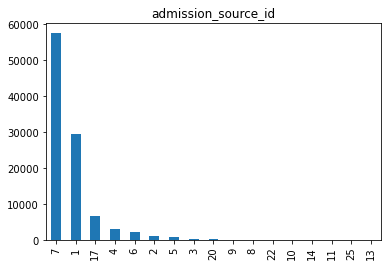

<AxesSubplot:title={'center':'tolbutamide'}>

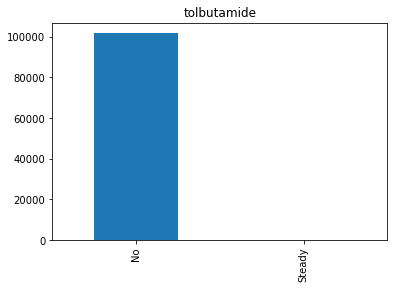

<AxesSubplot:title={'center':'change'}>

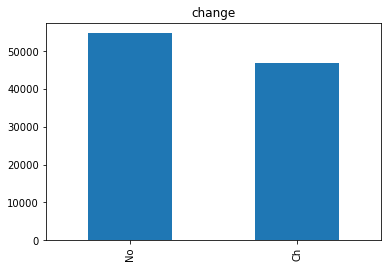

<AxesSubplot:title={'center':'age'}>

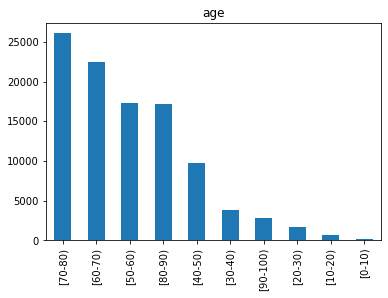

<AxesSubplot:title={'center':'glyburide-metformin'}>

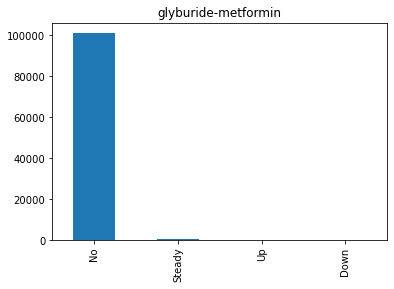

<AxesSubplot:title={'center':'citoglipton'}>

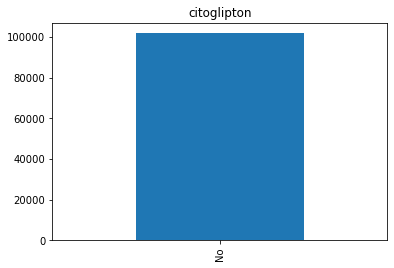

<AxesSubplot:title={'center':'metformin-rosiglitazone'}>

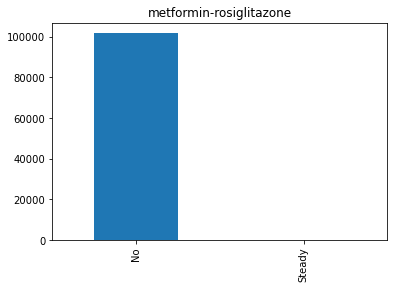

<AxesSubplot:title={'center':'glyburide'}>

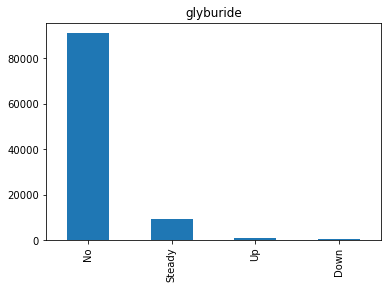

<AxesSubplot:title={'center':'max_glu_serum'}>

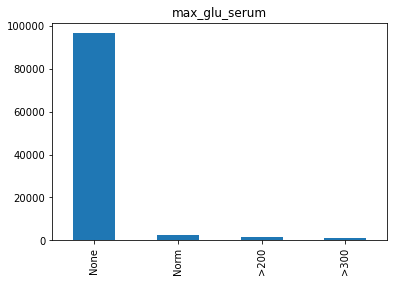

<AxesSubplot:title={'center':'glimepiride'}>

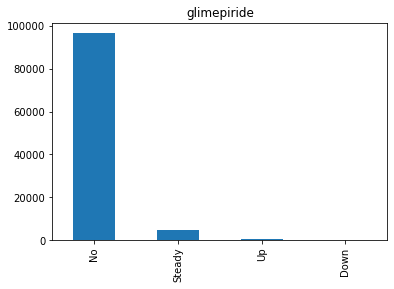

<AxesSubplot:title={'center':'gender'}>

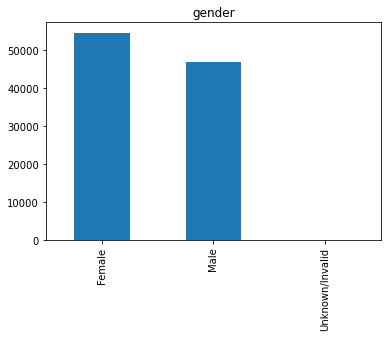

<AxesSubplot:title={'center':'acetohexamide'}>

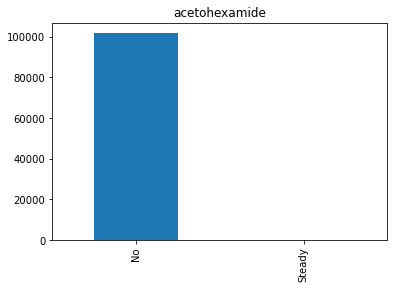

<AxesSubplot:title={'center':'nateglinide'}>

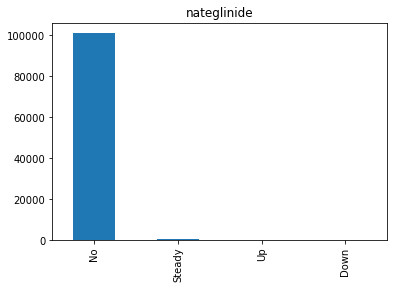

<AxesSubplot:title={'center':'glipizide'}>

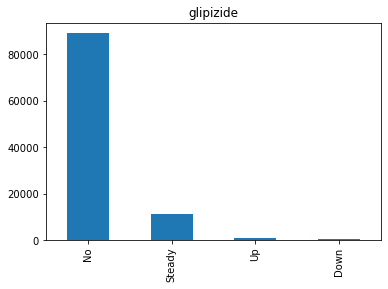

<AxesSubplot:title={'center':'miglitol'}>

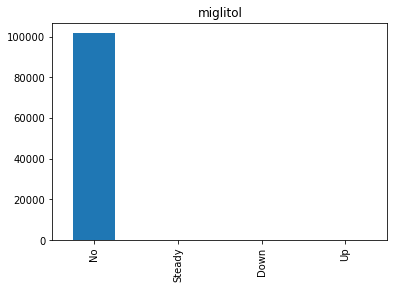

<AxesSubplot:title={'center':'glipizide-metformin'}>

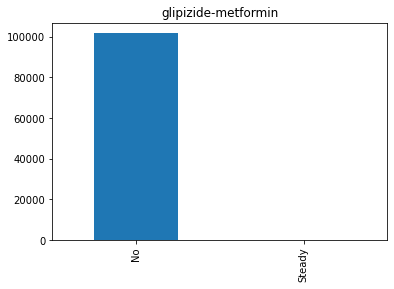

<AxesSubplot:title={'center':'metformin'}>

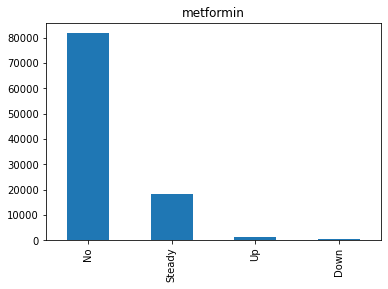

<AxesSubplot:title={'center':'repaglinide'}>

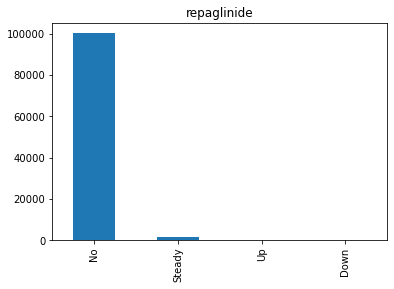

<AxesSubplot:title={'center':'insulin'}>

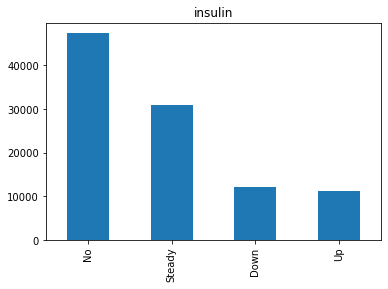

<AxesSubplot:title={'center':'diabetesMed'}>

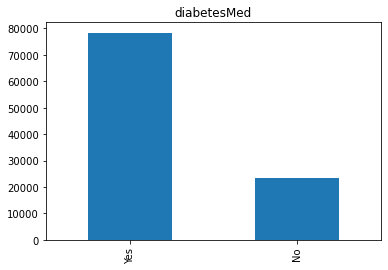

<AxesSubplot:title={'center':'pioglitazone'}>

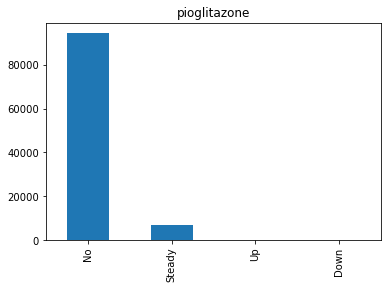

<AxesSubplot:title={'center':'A1Cresult'}>

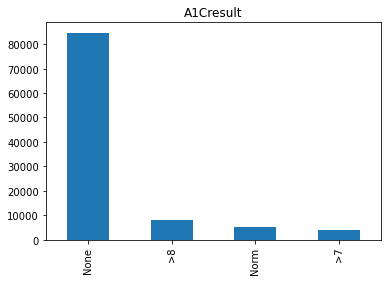

<AxesSubplot:title={'center':'payer_code'}>

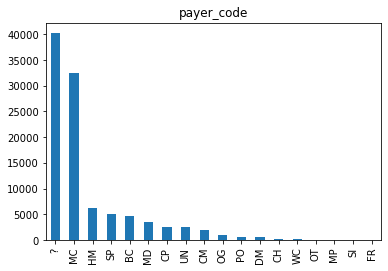

<AxesSubplot:title={'center':'tolazamide'}>

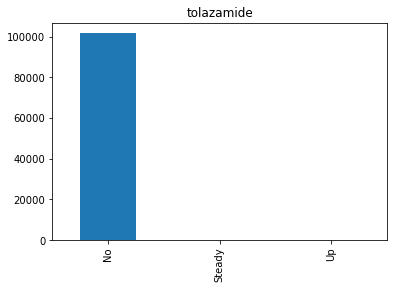

<AxesSubplot:title={'center':'race'}>

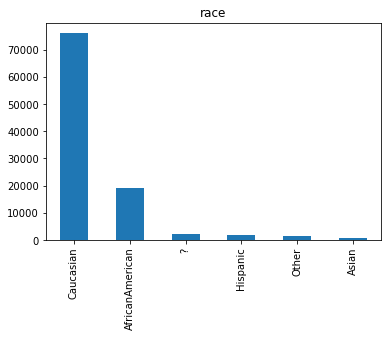

<AxesSubplot:title={'center':'chlorpropamide'}>

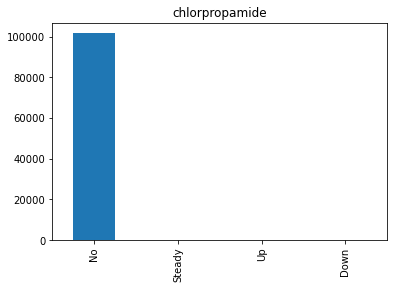

<AxesSubplot:title={'center':'acarbose'}>

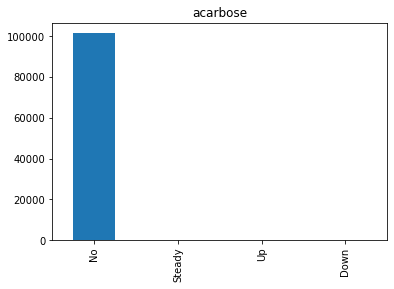

<AxesSubplot:title={'center':'rosiglitazone'}>

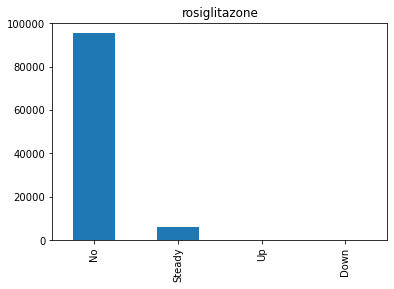

<AxesSubplot:title={'center':'troglitazone'}>

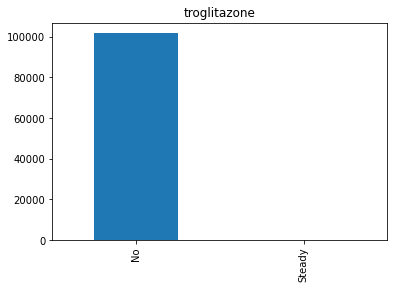

<AxesSubplot:title={'center':'metformin-pioglitazone'}>

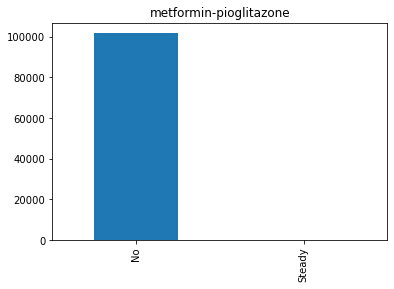

<AxesSubplot:title={'center':'admission_type_id'}>

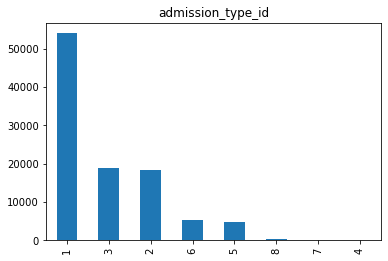

<AxesSubplot:title={'center':'glimepiride-pioglitazone'}>

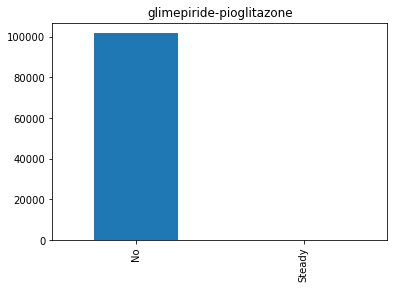

<AxesSubplot:title={'center':'examide'}>

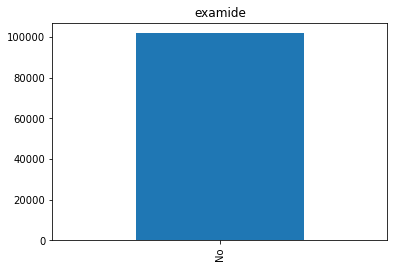

In [110]:
for col in list(set(cat_col) - set(high_cardinality)):
    df[col].value_counts(dropna=False).plot(kind='bar', title=col);
    plt.show();

* Features like `race`, `payer_code`, `medical_specialty`, `diag_1`, `diag_2`, and `diag_3` contain missing values. It may not be sensible to impute columns that are sensitive like race, medical specialty, and payer_code. So we can simply keep the 'unknown' category.

* Features like `A1Cresult` and `max_glue_serum` appear to be ordinal, so we could potentially use `OrdinalEncoder` for these features.

### Missing Ratios

In [181]:
# Obtain all columns that contain '?' 
cols_with_missing = list(compress(df.columns, df.apply(lambda x: x.isin(['?']).any(), axis=0)))
cols_with_missing

['race',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3']

<AxesSubplot:>

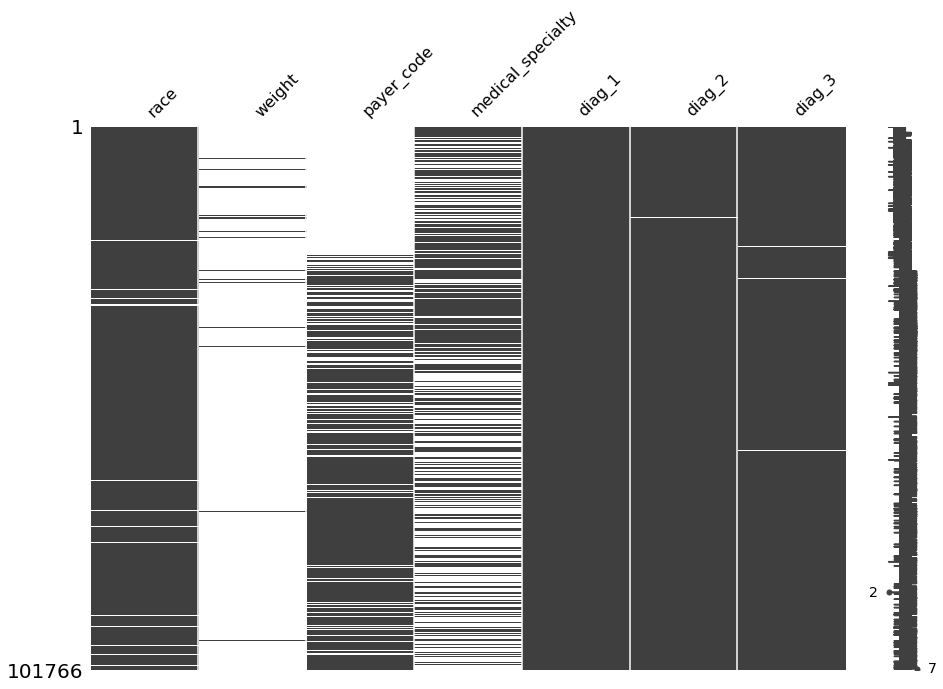

In [187]:
df_missing = df[cols_with_missing].copy(deep=True)
df_missing.replace('?', np.nan, inplace=True)
matrix(df_missing, figsize=(15, 10));
plt.savefig('../outputs/plots/eda_missing_matrix.png')

<AxesSubplot:>

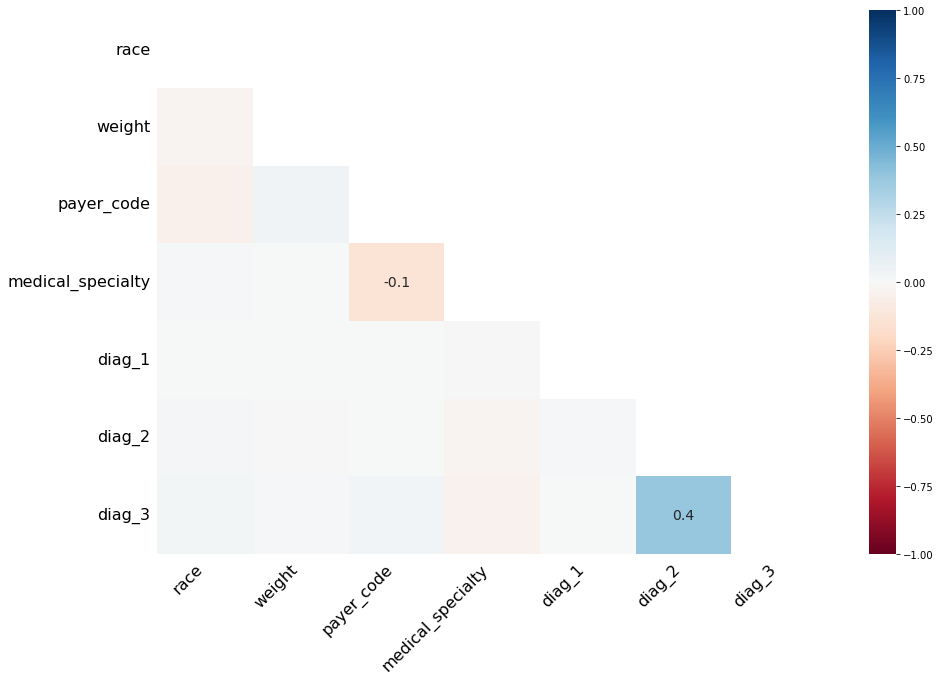

In [188]:
heatmap(df_missing, figsize=(15, 10));
plt.savefig('../outputs/plots/eda_missing_correlated.png')
del df_missing

* Diagnosis 2 and 3 are positively correlated, so their simultaneously missing may also be correlated. 

## Preprocessor Pipeline